In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

## Dữ liệu

In [2]:
RICE_URI = "https://raw.githubusercontent.com/thuongh2/FinalProject/main/data_final/Xoai/gia_xoai.csv"

In [3]:
df_rice = pd.read_csv(RICE_URI)

In [4]:
df_rice.head()

,date,price
0,11/20/2014,18000
1,11/21/2014,18000
2,11/22/2014,18000
3,11/23/2014,18000
4,11/24/2014,18000


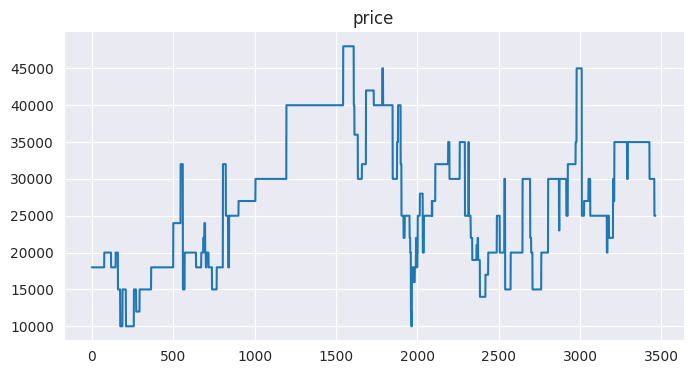

In [5]:
# @title EDA Data

from matplotlib import pyplot as plt
df_rice['price'].plot(kind='line', figsize=(8, 4), title='price')
plt.gca().spines[['top', 'right']].set_visible(False)

In [6]:
df_rice.set_index('date', inplace=True)

In [7]:
df_rice.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3464 entries, 11/20/2014 to 5/14/2024
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   price   3464 non-null   int64
dtypes: int64(1)
memory usage: 54.1+ KB


### Xử lí outlier

<Axes: >

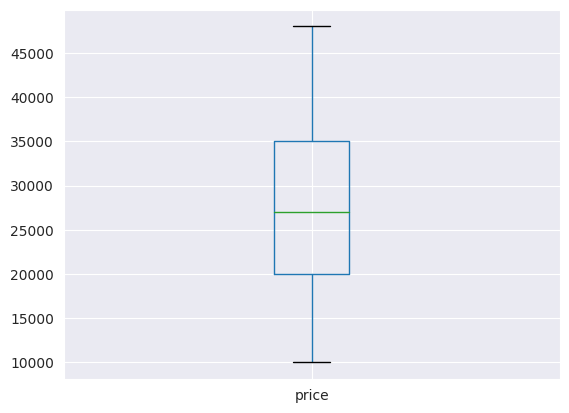

In [8]:
df_rice.boxplot()

In [9]:
# Tính toán ngưỡng cho outlier sử dụng IQR
Q1 = df_rice['price'].quantile(0.25)
Q3 = df_rice['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Xác định các dòng dữ liệu có giá trị nằm ngoài ngưỡng
outliers = df_rice[(df_rice['price'] < lower_bound) | (df_rice['price'] > upper_bound)]
print("Số lượng outlier:", len(outliers))

# Kiểm tra và thay đổi giá trị nếu nó nằm ngoài ngưỡng
df_rice.at[df_rice.index[0], 'price'] = min(max(df_rice.iloc[0]['price'], lower_bound), upper_bound)

# Thay thế giá trị của outlier bằng giá trị trước đó
for index, row in outliers.iterrows():
    previous_date_index = df_rice.index.get_loc(index) - 1
    if previous_date_index >= 0:
        previous_date = df_rice.index[previous_date_index]
        previous_value = df_rice.loc[previous_date, 'price']
        df_rice.at[index, 'price'] = previous_value

Số lượng outlier: 0


<Axes: >

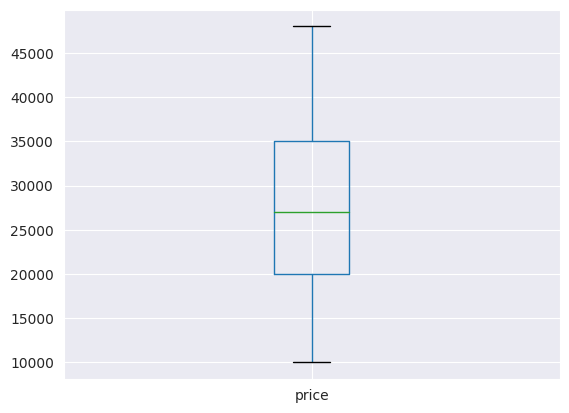

In [10]:
df_rice.boxplot()

<Axes: xlabel='date'>

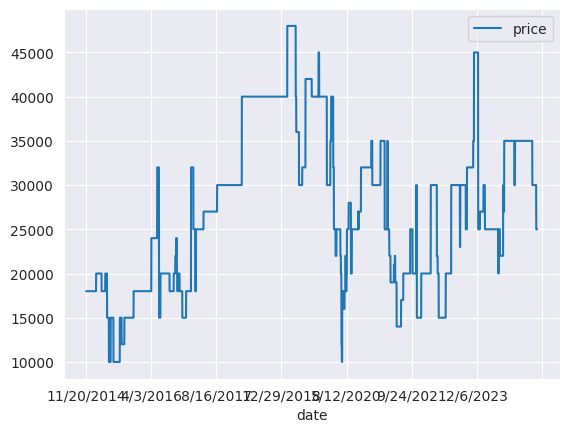

In [11]:
df_rice.plot()

### Smothing Data

In [12]:
df_rice = df_rice.rolling(30).mean()
df_rice = df_rice.dropna()

<Axes: xlabel='date'>

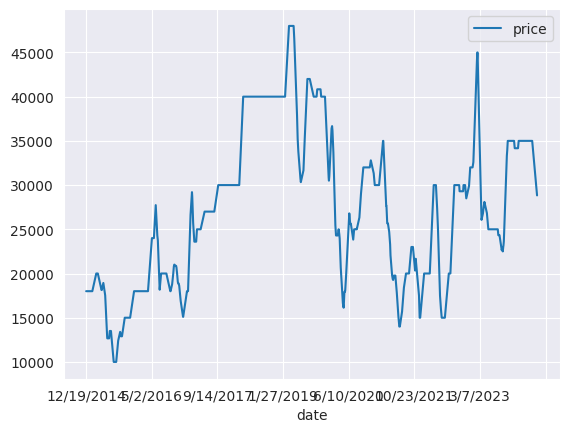

In [13]:
df_rice.plot()

# Kiểm tra tính dừng

In [14]:
def test_stationarity(timeseries):

    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=1).mean()
    movingSTD = timeseries.rolling(window=1).std()

    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='green', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)

    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

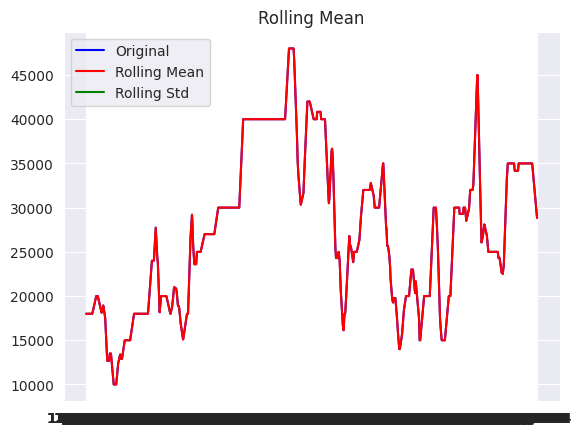

Results of Dickey Fuller Test:
Test Statistic                   -1.964841
p-value                           0.302199
#Lags Used                       30.000000
Number of Observations Used    3404.000000
Critical Value (1%)              -3.432273
Critical Value (5%)              -2.862389
Critical Value (10%)             -2.567222
dtype: float64


In [15]:
test_stationarity(df_rice.price)

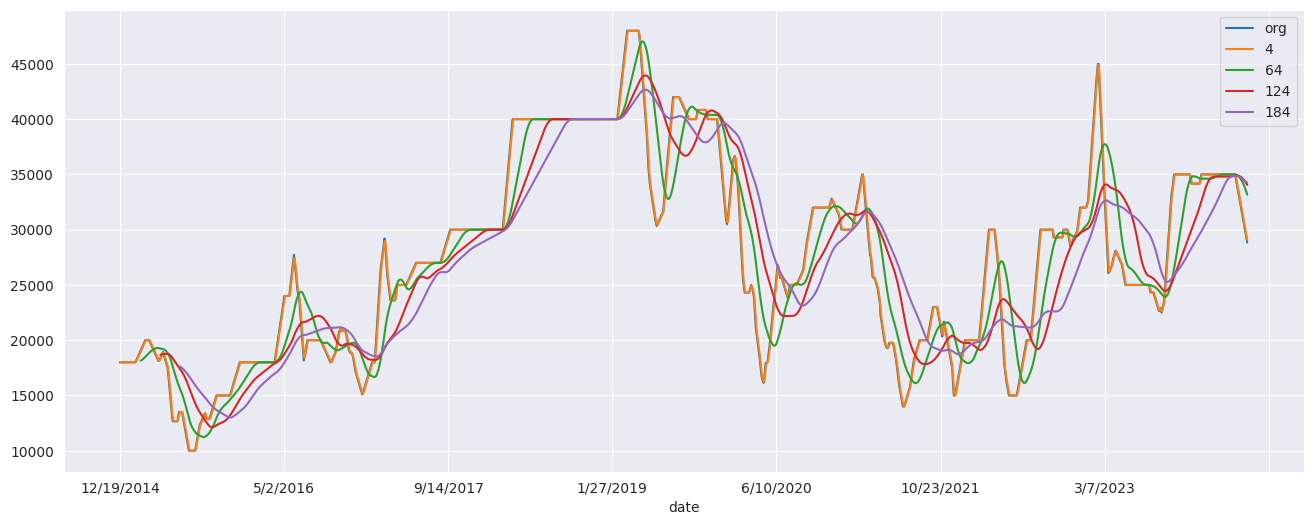

In [16]:
plt.figure(figsize=(16,6))
df_rice.price.plot(label="org")
for i in range(4,200,60):
    df_rice["price"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

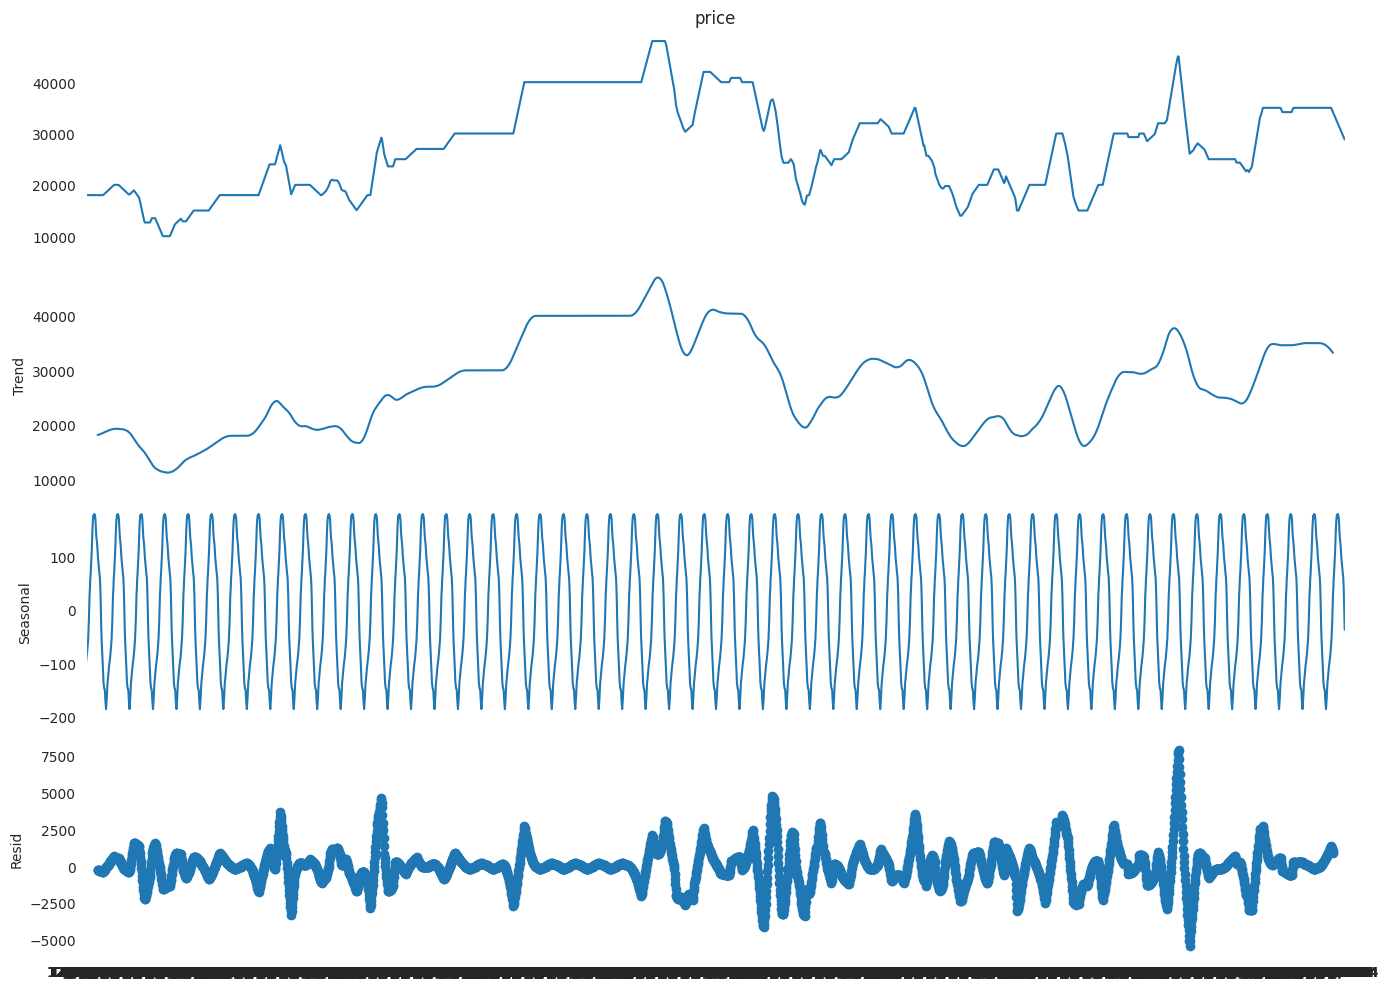

In [17]:
decompose_ts_add = seasonal_decompose(df_rice.price,period=64)
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

In [18]:
from statsmodels.tsa.stattools import pacf
pacf(df_rice.price, nlags=10)

array([ 1.        ,  0.99992381, -2.47162824, -0.73447658, -0.47952938,
       -0.40842172, -0.42328408, -0.52845265, -0.91418253, -9.65762107,
        1.10654702])

In [19]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(12,6))
    tsa_plots.acf(df_rice.price, nlags=10)
    plt.show()

In [20]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
    result = adfuller(series.dropna())
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    #for key,val in result[4].items():
        #out[f'critical value ({key})']=val
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [21]:
df1 = df_rice.price.copy()

### Các phương pháp thường được sử dụng

Sai phân (Diff): Để tính sai phân bậc một của chuỗi dữ liệu

Y_t​
 , công thức là:

 ΔYₜ = Yₜ - Yₜ₋₁


Sai phân theo mùa vụ (Seasonal Diff): Để tính sai phân theo mùa vụ của chuỗi dữ liệu với chu kỳ mùa vụ là
m (ví dụ: hàng năm)

ΔYₜ = Yₜ - Y_{t-m}


In [22]:
# create a differenced series
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return diff

In [23]:
# invert differenced forecast
def inverse_difference(last_ob, value):
  return value + last_ob

In [24]:
diff = difference(df1, 60)

In [25]:
from matplotlib import pyplot

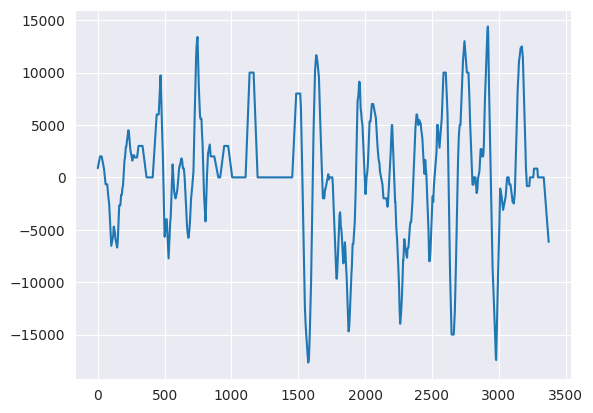

In [26]:
pyplot.plot(diff)
pyplot.show()

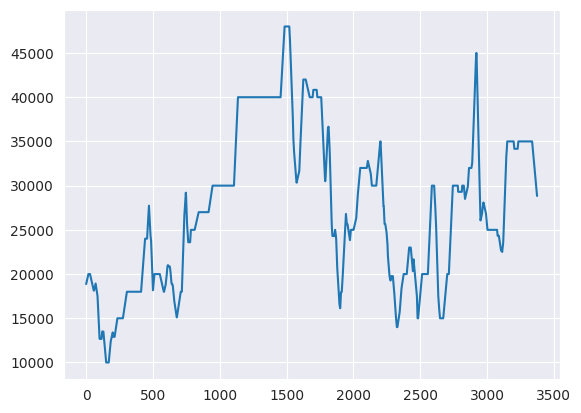

In [27]:
# invert the difference
inverted = [inverse_difference(df1[i], diff[i]) for i in range(len(diff))]
pyplot.plot(inverted)
pyplot.show()

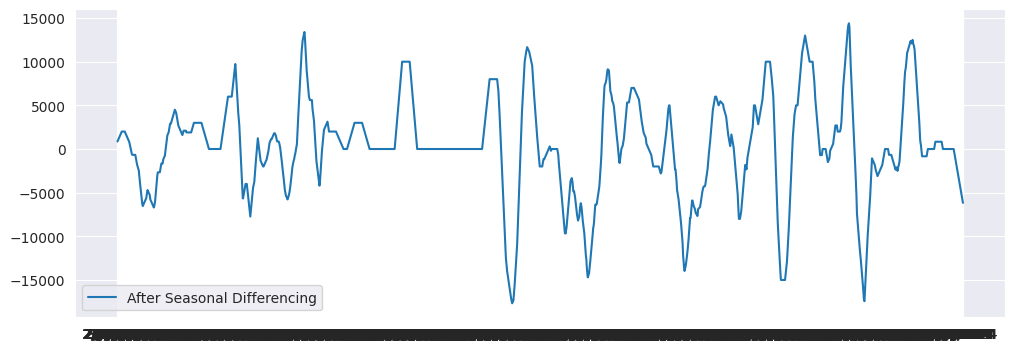

In [28]:
seasonal_differencing = df1 - df1.shift(60)
seasonal_differencing.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(seasonal_differencing, label='After Seasonal Differencing')
plt.legend(loc='best')
plt.show()

In [29]:
def revert_tranform_seasonal(df):
  return df + df.shift(60)

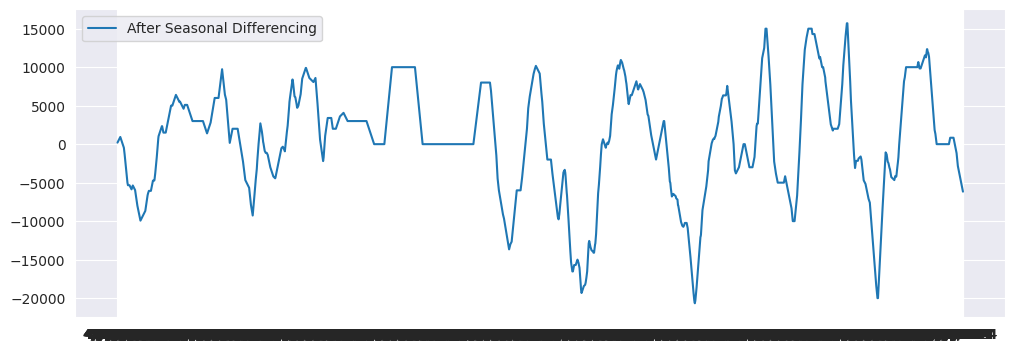

In [30]:
seasonal_revert = revert_tranform_seasonal(seasonal_differencing)
seasonal_revert.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(seasonal_revert, label='After Seasonal Differencing')
plt.legend(loc='best')
plt.show()

<Axes: xlabel='date'>

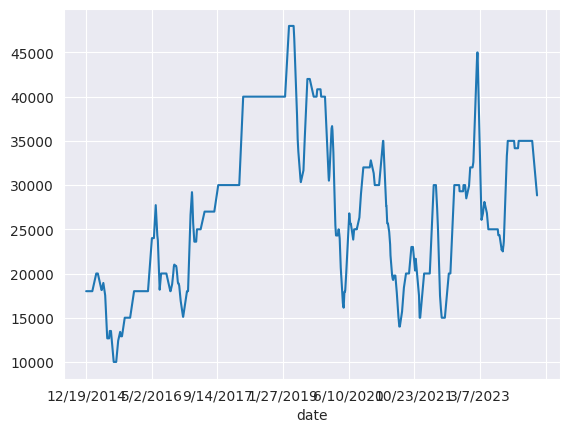

In [31]:
df1.plot()

### Log Scale Transformation

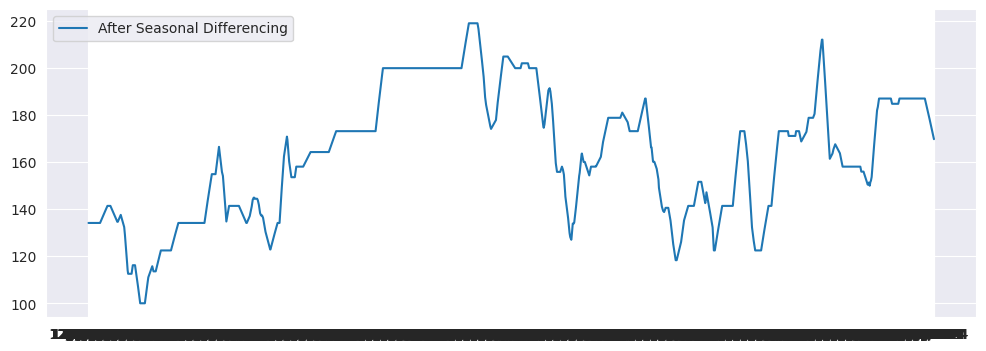

In [32]:
seasonal_box_plot = np.sqrt(df1)
seasonal_box_plot.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(seasonal_box_plot, label='After Seasonal Differencing')
plt.legend(loc='best')
plt.show()

In [33]:
def revert_tranform_seasonal(df):
  return np.square(df)

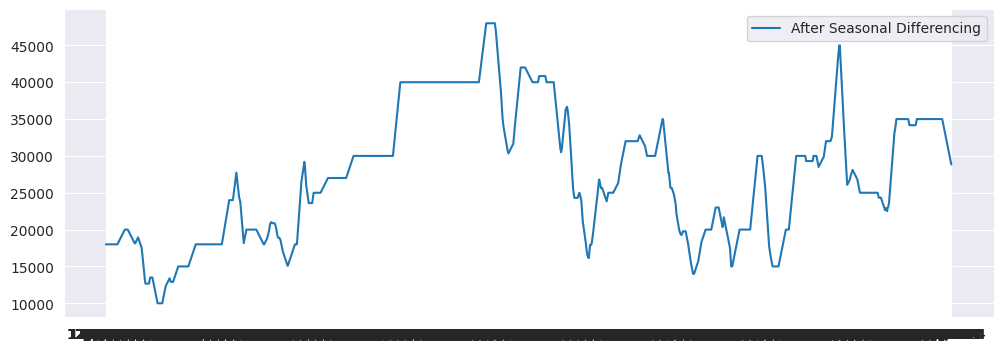

In [34]:
seasonal_revert = revert_tranform_seasonal(seasonal_box_plot)
seasonal_revert.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(seasonal_revert, label='After Seasonal Differencing')
plt.legend(loc='best')
plt.show()

In [35]:
adf_test(seasonal_box_plot)

Fail to reject the null hypothesis
Data is non-stationary


In [36]:
seasonal_differencing.info()

<class 'pandas.core.series.Series'>
Index: 3375 entries, 2/17/2015 to 5/14/2024
Series name: price
Non-Null Count  Dtype  
--------------  -----  
3375 non-null   float64
dtypes: float64(1)
memory usage: 52.7+ KB


In [37]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.4 MB/s eta 0:00:00


In [38]:
df_rice.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3435 entries, 12/19/2014 to 5/14/2024
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   3435 non-null   float64
dtypes: float64(1)
memory usage: 53.7+ KB


In [39]:
df1 = df1.copy()

In [40]:
# df1['price'] = df_rice["price"].rolling(60).mean()

In [41]:
df1

date
12/19/2014    18000.000000
12/20/2014    18000.000000
12/21/2014    18000.000000
12/22/2014    18000.000000
12/23/2014    18000.000000
                  ...     
5/10/2024     29500.000000
5/11/2024     29333.333333
5/12/2024     29166.666667
5/13/2024     29000.000000
5/14/2024     28833.333333
Name: price, Length: 3435, dtype: float64

In [42]:
df1 = df1.dropna()


In [43]:
df1.info()

<class 'pandas.core.series.Series'>
Index: 3435 entries, 12/19/2014 to 5/14/2024
Series name: price
Non-Null Count  Dtype  
--------------  -----  
3435 non-null   float64
dtypes: float64(1)
memory usage: 53.7+ KB


In [44]:
size = int(len(df1) * 0.7)
train_data = df1[:size]
test_data = df1[size:]

In [45]:
train_data =  train_data.diff()

In [46]:
train_data = train_data.dropna()

In [47]:
train_data.info()

<class 'pandas.core.series.Series'>
Index: 2403 entries, 12/20/2014 to 7/18/2021
Series name: price
Non-Null Count  Dtype  
--------------  -----  
2403 non-null   float64
dtypes: float64(1)
memory usage: 37.5+ KB


In [48]:
adf_test(train_data)

Reject the null hypothesis
Data is stationary


<Axes: xlabel='date'>

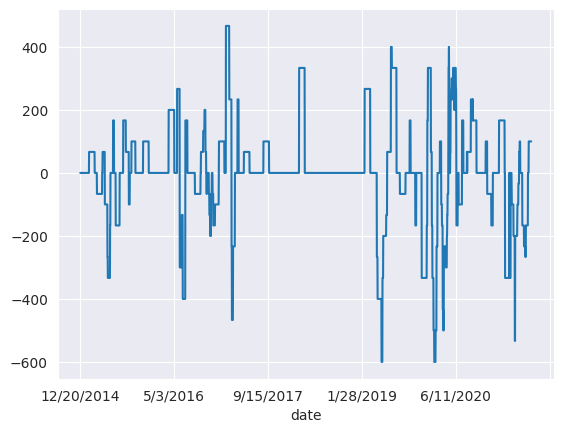

In [49]:
train_data.plot()

In [50]:
diff_data = train_data.copy()
diff_data.iloc[0] = train_data.iloc[0]

# Compute the cumulative sum to revert the diff transformation
reverted_data = diff_data.cumsum()

<Axes: xlabel='date'>

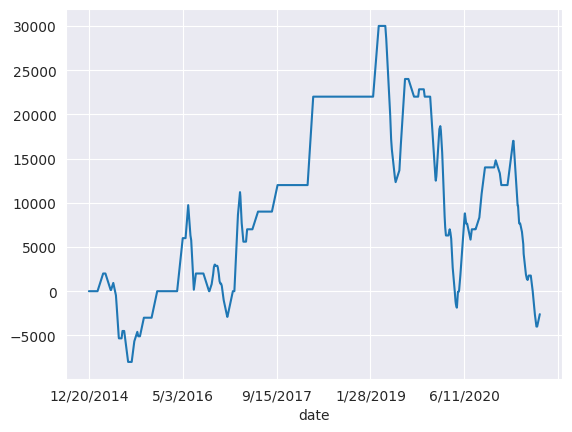

In [51]:
reverted_data.plot()

In [52]:
size

2404

In [53]:
train_data.values

array([  0.,   0.,   0., ..., 100., 100., 100.])

## ARIMA MODEL

Mô hình ARIMA: Dựa trên giả thuyết chuỗi dừng và phương sai sai số không đổi. Mô hình sử dụng đầu vào chính là những tín hiệu quá khứ của chuỗi được dự báo để dự báo nó. Các tín hiệu đó bao gồm: chuỗi tự hồi qui AR (auto regression) và chuỗi trung bình trượt MA (moving average). Hầu hết các chuỗi thời gian sẽ có xu hướng tăng hoặc giảm theo thời gian, do đó yếu tố chuỗi dừng thường không đạt được. Trong trường hợp chuỗi không dừng thì ta sẽ cần biến đổi sang chuỗi dừng bằng sai phân. Khi đó tham số đặc trưng của mô hình sẽ có thêm thành phần bậc của sai phân d và mô hình được đặc tả bởi 3 tham số ARIMA(p, d, q).


Xt=α1Xt−1+⋯+αpXt−p+εt+θ1εt−1+⋯+θqεt−q

Tham khảo: https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ARIMA.html

In [54]:
import pmdarima as pm

model_arima = pm.auto_arima(train_data.values, start_p=2, start_q=2,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=2, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=False,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model_arima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=25423.859, Time=1.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=25416.967, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=25418.674, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=25418.681, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=25414.969, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=25420.013, Time=1.36 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.371 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2403
Model:               SARIMAX(0, 1, 0)   Log Likelihood              -12706.484
Date:                Tue, 18 Jun 2024   AIC                          25414.969
Time:                        02:07:26   BIC                          25420.753
Sample:                             0   HQIC                         25417.073
    

Kiểm tra kết quả

In [55]:
n_periods = len(test_data)
fc, confint = model_arima.predict(n_periods=n_periods, return_conf_int=True, dynamic=True)
index_of_fc = np.arange(len(test_data), len(test_data.values) + n_periods)

In [56]:
import joblib
joblib.dump(model_arima, 'gia_cam.joblib')

['gia_cam.joblib']

In [57]:
from google.colab import files
files.download('gia_cam.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [58]:
np.square(fc)

array([10000., 10000., 10000., ..., 10000., 10000., 10000.])

In [59]:
fc_series = pd.Series(fc, index=test_data.index)

In [60]:
test_data.info()

<class 'pandas.core.series.Series'>
Index: 1031 entries, 7/19/2021 to 5/14/2024
Series name: price
Non-Null Count  Dtype  
--------------  -----  
1031 non-null   float64
dtypes: float64(1)
memory usage: 16.1+ KB


<Axes: xlabel='date'>

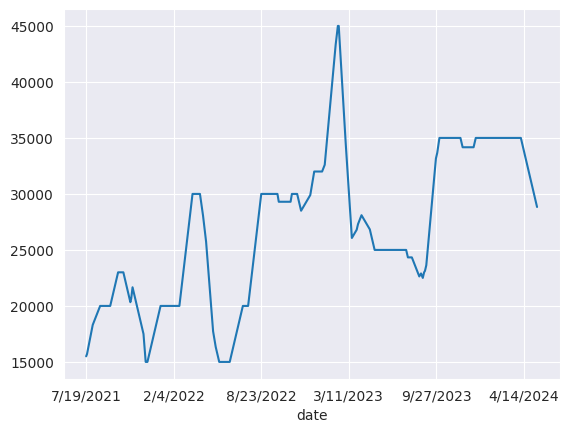

In [61]:
test_data.plot()

<Axes: xlabel='date'>

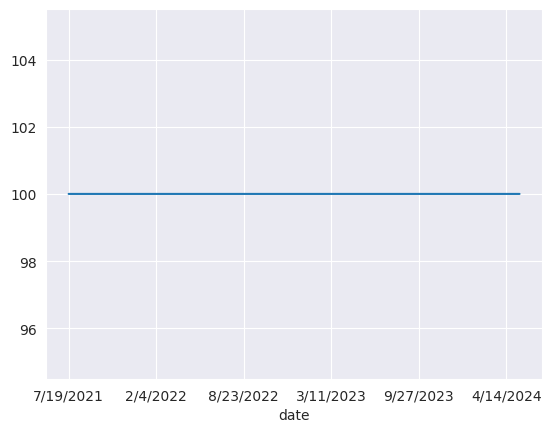

In [62]:
fc_series.plot()

In [63]:
diff_data.cumsum()

date
12/20/2014       0.0
12/21/2014       0.0
12/22/2014       0.0
12/23/2014       0.0
12/24/2014       0.0
               ...  
7/14/2021    -3000.0
7/15/2021    -2900.0
7/16/2021    -2800.0
7/17/2021    -2700.0
7/18/2021    -2600.0
Name: price, Length: 2403, dtype: float64

In [64]:
diff_data = fc_series.copy()

reverted_data = test_data.iloc[0] + diff_data.cumsum()
# Compute the cumulative sum to revert the diff transformation


In [65]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        df_res[str(col)+'_forecast'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

<Axes: xlabel='date'>

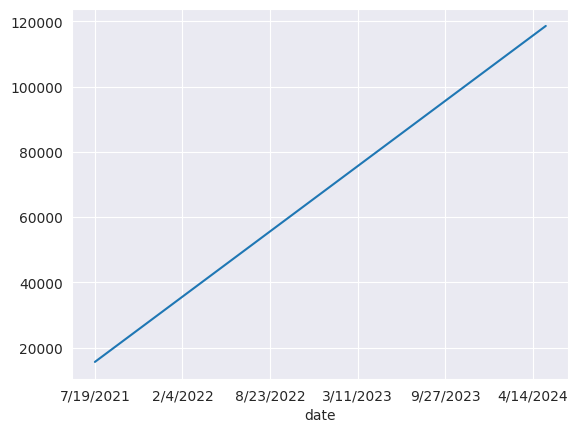

In [66]:
reverted_data.plot()

In [67]:
test_data

date
7/19/2021    15500.000000
7/20/2021    15600.000000
7/21/2021    15700.000000
7/22/2021    15900.000000
7/23/2021    16100.000000
                 ...     
5/10/2024    29500.000000
5/11/2024    29333.333333
5/12/2024    29166.666667
5/13/2024    29000.000000
5/14/2024    28833.333333
Name: price, Length: 1031, dtype: float64

<Axes: xlabel='date'>

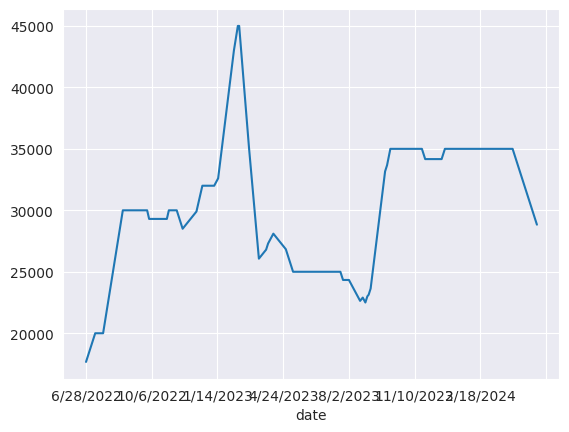

In [68]:
df1[int(len(df1)*0.8):].plot()

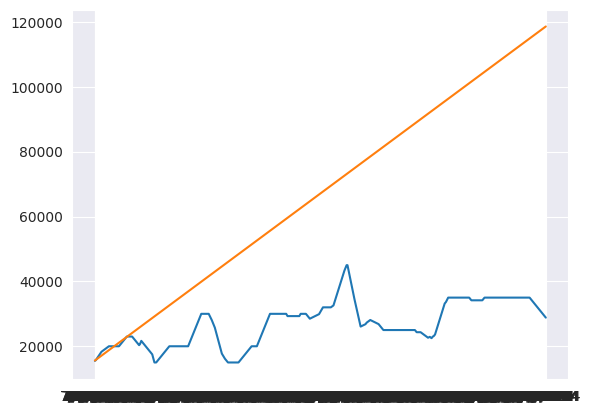

In [69]:
#plot the predictions for validation set
# plt.plot(train_data_inverse, label='Train')
plt.plot(test_data, label='Valid')
plt.plot(reverted_data, label='Prediction')
plt.show()

In [70]:
rmse = sqrt(mean_squared_error(test_data.values, reverted_data))
rmse

47495.78031296517

In [71]:
from sklearn.metrics import mean_absolute_percentage_error

def forecast_accuracy(forecast, actual):
    mape = mean_absolute_percentage_error(actual, forecast) * 100  # MAPE     # ME
    rmse = np.mean((forecast - actual)**2)**.5  # RMS
    return({'mape':mape, 'rmse':rmse})

In [72]:
forecast_accuracy(test_data.values, reverted_data.values)

{'mape': 52.54740483008701, 'rmse': 47495.78031296517}

In [74]:
import joblib
from google.colab import drive

file_name = "arima_gia_xoai.joblib"
drive.mount('/content/drive')

joblib.dump(model_arima, '/content/drive/MyDrive/model/' + file_name)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['/content/drive/MyDrive/model/arima_gia_xoai.joblib']